In [1]:
import numpy as np
import torch
import os

def generate_sine_wave(shape, frequency, amplitude, phase):
    
    """Generate a 3D sine wave pattern."""
    x = np.linspace(0, 2 * np.pi, shape[0])
    y = np.linspace(0, 2 * np.pi, shape[1])
    z = np.linspace(0, 2 * np.pi, shape[2])
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    sine_wave = amplitude * np.sin(frequency * (X + Y + Z) + phase)
    return sine_wave

def generate_linear_gradient(shape, start, end):

    """Generate a 3D linear gradient pattern."""
    gradient = np.linspace(start, end, num=shape[0])
    gradient = np.expand_dims(np.tile(gradient, (shape[1], shape[2], 1)).T,-1)
    gradient = np.repeat(gradient, 3, axis=-1)
    return gradient

def add_noise(data, noise_level):

    """Add random noise to the data."""
    noise = noise_level * np.random.randn(*data.shape)
    return data + noise

def generate_synthetic_data(shape, num_samples, noise_level=0.2):

    """Generate synthetic 3D CFD data with regular patterns and variations."""
    data = []
    for _ in range(num_samples):
        frequency = np.random.uniform(10.0, 20.0)  # Random frequency between 32 and 64
        amplitude = np.random.uniform(0.0, 1.0)  # Random amplitude between 0.5 and 2.0
        phase = np.random.rand() * 2 * np.pi     # Random phase between 0 and 2*pi
        sine_wave = np.expand_dims(generate_sine_wave(shape, frequency, amplitude, phase),-1)
        cosine_wave = np.expand_dims(generate_sine_wave(shape, frequency, amplitude, phase + np.pi/2), -1)
        wave = np.concatenate((sine_wave, cosine_wave, sine_wave - cosine_wave), axis=-1)
        gradient = generate_linear_gradient(wave.shape, start=0, end=1)
        combined_pattern = wave + gradient
        noisy_pattern = add_noise(combined_pattern, noise_level)
        data.append(noisy_pattern)
        
    return np.array(data)

def save_data_as_pt(data, directory, prefix):

    """Save the generated data as .pt files."""
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i, sample in enumerate(data):
        tensor = torch.from_numpy(sample).float()
        torch.save(tensor, os.path.join(directory, f"{prefix}_{i}.pt"))

# Parameters
shape = (21, 21, 21)
num_samples = 1000
noise_level = 0.1
output_directory = "synthetic_cfd_data"
file_prefix = "sample"

# Generate and save data
synthetic_data = generate_synthetic_data(shape, num_samples, noise_level)
save_data_as_pt(synthetic_data, output_directory, file_prefix)

print(f"Generated and saved {num_samples} samples in '{output_directory}' directory.")

Generated and saved 100 samples in 'synthetic_cfd_data' directory.


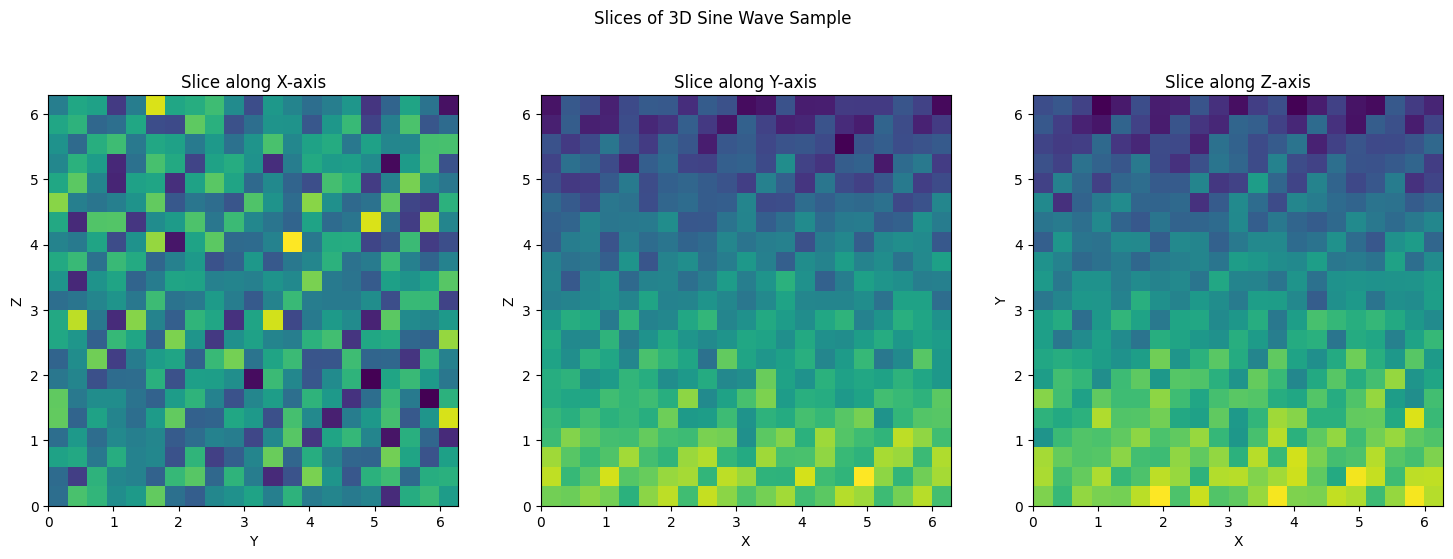

In [2]:
import matplotlib.pyplot as plt

# Select the first sample
sample = synthetic_data[90]

# Plot the sample
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create a grid for the plot
x = np.linspace(0, 2 * np.pi, shape[0])
y = np.linspace(0, 2 * np.pi, shape[1])
z = np.linspace(0, 2 * np.pi, shape[2])
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Plot slices of the 3D volume
slices = [shape[0] // 2, shape[1] // 2, shape[2] // 2]
axes[0].imshow(sample[slices[0], :, :,1], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[0].set_title('Slice along X-axis')
axes[0].set_xlabel('Y')
axes[0].set_ylabel('Z')

axes[1].imshow(sample[:, slices[1], :, 1], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[1].set_title('Slice along Y-axis')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Z')

axes[2].imshow(sample[:, :, slices[2],1], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[2].set_title('Slice along Z-axis')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')

plt.suptitle('Slices of 3D Sine Wave Sample')
plt.show()

In [3]:
from datasets import Field3DDataset

# Define a custom transform (if needed)
def custom_transform(sample):
    # Example transform: normalize the sample
    return (sample - np.mean(sample)) / np.std(sample)

# Initialize the dataset
data_directory = r'C:\Users\apost\OneDrive\Documents\GitHub\Convolutional-VAE-for-3D-Turbulence-Data\synthetic_cfd_data'  # Use the directory where synthetic data is saved
no_simulations = num_samples       # Number of samples generated
simulation_timesteps = 1           # Assuming each sample is a single timestep

# Create an instance of the CFD3DDataset
dataset = Field3DDataset(data_directory=data_directory)

# Access a sample from the dataset
sample_idx = 30
sample = dataset[sample_idx]
print(sample.shape)

# Print the shape of the sample
print(f"Sample {sample_idx} shape: {sample.shape}")

# If the sample is a tensor, convert it to a numpy array for visualization
if isinstance(sample, torch.Tensor):
    sample = sample.numpy()[0]

# Plot the sample
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot slices of the 3D volume
slices = [shape[0] // 2, shape[1] // 2, shape[2] // 2]
axes[0].imshow(sample[slices[0], :, :], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[0].set_title('Slice along X-axis')
axes[0].set_xlabel('Y')
axes[0].set_ylabel('Z')

axes[1].imshow(sample[:, slices[1], :], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[1].set_title('Slice along Y-axis')
axes[1].set_xlabel('X')
axes[1].set_ylabel('Z')

axes[2].imshow(sample[:, :, slices[2]], cmap='viridis', extent=(0, 2 * np.pi, 0, 2 * np.pi))
axes[2].set_title('Slice along Z-axis')
axes[2].set_xlabel('X')
axes[2].set_ylabel('Y')

plt.suptitle('Slices of 3D CFD Dataset Sample')
plt.show()


NameError: name 'num_samples' is not defined

In [4]:
from tqdm import tqdm
import torch
from torch.nn import functional as F
import numpy as np
import pdb

def schedule_KL_annealing(start, stop, n_epochs, n_cycle=4, ratio=0.5):
    """
    Custom function for multiple annealing scheduling: Monotonic and cyclical_annealing
    Given number of epochs, it returns the value of the KL weight at each epoch as a list.

    Based on from: https://github.com/haofuml/cyclical_annealing/blob/master/plot/plot_schedules.ipynb
    """

    weights = np.ones(n_epochs)
    period = n_epochs/n_cycle
    step = (stop-start)/(period*ratio) # linear schedule

    for c in range(n_cycle):
        v , i = start , 0
        while v <= stop and (int(i+c*period) < n_epochs):
            weights[int(i+c*period)] = v
            v += step
            i += 1

    return weights

def loss_function(recon_x, x, mu, logvar, kl_weight):
    
    """
    Computes binary cross entropy and analytical expression of KL divergence used to train Variational Autoencoders

    Losses are calculated per batch (recon vs original). Their sizes are torch.Size([128, 3, 21, 21, 21])

    Total loss is reconstruction + KL divergence summed over batch
    """
    
    # reconstruction loss (MSE/BCE for image-like data)
    # CE = torch.nn.CrossEntropyLoss()(recon_x, x)
    # MSE = torch.nn.MSELoss(reduction='mean')(recon_x, x)
    MSE = 0.1 * torch.nn.MSELoss(reduction='sum')(recon_x, x)
    # BCE = F.binary_cross_entropy(recon_x, x, reduction="mean") # only takes data in range [0, 1]
    # BCEL = torch.nn.BCEWithLogitsLoss(reduction="mean")(recon_x, x)

    # KL divergence loss (with annealing)
    # KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) # sum or mean
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # KLD = KLD * kl_weight

    return MSE + KLD, MSE, KLD


def train(epoch, model, train_loader, kl_weight, optimizer, device, scheduler, args):
    """
    Mini-batch training.
    """

    model.train()
    train_total_loss = 0
    train_BCE_loss = 0
    train_KLD_loss = 0

    print("entered batch training")
    print("train device:", device)
    for batch_idx, data in tqdm(enumerate(train_loader), total=len(train_loader), desc='train'):

        # move data into GPU tensors
        data = data.to(device, dtype=torch.float)

        # reset gradients
        optimizer.zero_grad()

        # call CVAE model
        # feeding 3D volume to Conv3D: https://discuss.pytorch.org/t/feeding-3d-volumes-to-conv3d/32378/6
        recon_batch, mu, logvar, _ = model(data)

        # compute batch losses
        total_loss, BCE_loss, KLD_loss = loss_function(recon_batch, data, mu, logvar, kl_weight)

        train_total_loss += total_loss.item()
        train_BCE_loss += BCE_loss.item()
        train_KLD_loss += KLD_loss.item()

        # compute gradients and update weights
        total_loss.backward()
        optimizer.step()

        # schedule learning rate
        scheduler.step()

    train_total_loss /= len(train_loader.dataset)
    train_BCE_loss /= len(train_loader.dataset)
    train_KLD_loss /= len(train_loader.dataset)

    return train_total_loss, train_BCE_loss, train_KLD_loss

In [5]:
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import Field3DDataset
from models import CVAE_3D
from utils import init_weights
# from torch.utils.tensorboard import SummaryWriter

# Set variables
result_dir = 'results'
seed = 1
batch_size = 32
epochs = 100
h_dim = 128
z_dim = 64
test_every_epochs = 1
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

data_dir = r'C:\Users\apost\OneDrive\Documents\GitHub\Convolutional-VAE-for-3D-Turbulence-Data\synthetic_cfd_data'

# Create results directory
os.makedirs(result_dir, exist_ok=True)

# Simulation parameters
no_simulations = 96  # individual npy files
simulation_timesteps = 100  # time steps per simulation
IMG_DIM = 21  # cube dimensions
cube_channels = 3  # 3 velocity components (analogue to RGB)

# Define transforms
transformations = transforms.Compose([transforms.ToTensor()])

# Define custom 3D dataset
CFD_3D_dataset = Field3DDataset(data_dir)

# Split train, validation sets
train_set, val_set = torch.utils.data.random_split(CFD_3D_dataset,
                                                   [int(len(CFD_3D_dataset) * 0.7),
                                                    int(len(CFD_3D_dataset) * 0.3)])

# Create data loaders
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

# Instantiate model and initialize network weights
model = CVAE_3D(image_channels=cube_channels, h_dim=h_dim, z_dim=z_dim).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader))

# Initialize SummaryWriter for TensorBoard

# Schedule KL annealing
def schedule_KL_annealing(start, end, epochs, cycle_length):

    kl_weights = []
    for epoch in range(epochs):
        cycle_position = (epoch % cycle_length) / cycle_length
        kl_weight = start + (end - start) * cycle_position
        kl_weights.append(kl_weight)
    return kl_weights

kl_weights = schedule_KL_annealing(0.0, 1.0, epochs, 4)  # cyclical annealing

# Training loop
for epoch in range(epochs):
    print(f"[INFO] Epoch {epoch}")
    kl_weight = kl_weights[epoch]
    print("current KL weight:", kl_weight)
    train_total_loss, train_BCE_loss, train_KLD_loss = train(epoch, model, train_loader, kl_weight, optimizer, device, scheduler, None)
    print(f"Epoch [{epoch}/{epochs}] train_total_loss: {train_total_loss:.3f}, train_REC_loss: {train_BCE_loss:.3f}, train_KLD_loss: {train_KLD_loss:.3f}")

print("[INFO] Training completed")

[INFO] started instantiating 3D CFD pytorch dataset


c:\Users\apost\OneDrive\Documents\GitHub\Convolutional-VAE-for-3D-Turbulence-Data\datasets.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_cube = torch.load(data_f

[INFO] Epoch 0
current KL weight: 0.0
entered batch training
train device: cpu


train:   0%|          | 0/219 [00:00<?, ?it/s]c:\Users\apost\OneDrive\Documents\GitHub\Convolutional-VAE-for-3D-Turbulence-Data\datasets.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

RuntimeError: Given groups=1, weight of size [16, 3, 4, 4, 4], expected input[32, 21, 21, 21, 3] to have 3 channels, but got 21 channels instead

In [ ]:
442368 